# **Final Predictions**
---

This notebook combines the trained classification models (Smart-seq and Drop-seq) to perform final predictions on the held-out external test sets. We apply soft-voting ensembles based on the best-performing classifiers from cross-validation, and generate tab-delimited outputs with predicted labels per cell.

We ensure reproducibility by loading saved models and applying them to consistently preprocessed test data. The ensembling strategy prioritizes interpretability and robustness.

> Each step is repeated for both **Smart-seq** and **Drop-seq** datasets, maintaining the same methodology for consistent comparison and integration.

## Index

1. [Load Final Gene Lists](#1-load-final-gene-lists)  
2. [Load and Align External Test Sets](#2-load-and-align-external-test-sets)   
3. [Ensembling](#3-ensembling)
4. [Export Final Predictions](#4-export-final-predictions)
5. [SHAP Interpretation](#5-shap-interpretation)
6. [Conclusion](#6-conclusion)


In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from pathlib import Path
import shap
from scipy.special import expit

## **1.** Load Final Gene Lists
---

We load the gene sets selected for Smart-seq and Drop-seq. These represent the minimal robust gene subsets used by the final classifiers.

#### ***SmartSeq***


In [2]:
with open("stable_genes_hcc_smart.txt") as f:
    stable_genes_smart = [line.strip() for line in f if line.strip()]

#### ***DropSeq***

In [3]:
with open("stable_genes_hcc_drop.txt") as f:
    stable_genes_drop = [line.strip() for line in f if line.strip()]

## **2.** Load and Align External Test Sets
---

We preprocess the external test matrices to match the training format. Only the selected genes are used for prediction, as expected by the saved models.

#### ***SmartSeq***

In [4]:
# Load Smart-seq test
df_test_smart = pd.read_csv("../Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt", sep=r"\s+", engine= "python", index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"')).T
X_test_smart = df_test_smart[stable_genes_smart]

#### ***DropSeq***

In [5]:
df_test_drop = pd.read_csv("../Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_test_anonim.txt", sep=r"\s+", engine= "python", index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"')).T
X_test_drop = df_test_drop[stable_genes_drop]

## **3.** Ensembling  
---


During cross-validation, several classifiers were evaluated on the HCC training dataset, including Logistic Regression, Support Vector Machines, Random Forests, K-Nearest Neighbors, MLPs, and XGBoost.  
We observed that multiple models achieved **strong and comparable performance** on both Smart-seq and Drop-seq datasets, with **F1 scores exceeding 0.98** for Smart-seq and **above 0.90** for Drop-seq in the best cases.

Instead of including all models in the ensemble, we selected the **top 2–3 per technology** based on:
- **Cross-validated performance** (primarily F1 Score, Accuracy, Precision, and Recall)
- **Model diversity** (e.g., linear, neural, kernel-based)
- **Generalization potential**, avoiding redundant or overfitting-prone classifiers

This resulted in the following model ensembles for HCC predictions:
- **Smart-seq**: SVM, KNN, Logistic Regression  
- **Drop-seq**: SVM, XGBoost, Logistic Regression  

We then generate final predictions on the external test sets using a **soft-voting ensemble** of the top 3 models per technology. For each cell, we average the predicted class probabilities from all ensemble members and apply a **0.5 threshold** to obtain binary class labels (0 = Normoxia, 1 = Hypoxia).

This method allows us to integrate diverse decision boundaries while smoothing out individual model variance, yielding **robust and generalizable final predictions** specific to the HCC cell line.


In [6]:
def load_model(name, path, suffix="HCC"):
    model_path = Path(path) / f"{name}.{suffix}.pkl"
    if not model_path.exists():
        raise FileNotFoundError(f"Model file not found: {model_path}")
    with open(model_path, "rb") as f:
        return pickle.load(f)


### ***SmartSeq***


Despite both **SVM** and **KNN** achieving exceptionally high performance on the held‐out HCC Smart-seq test set (F1 Score = 0.98, Accuracy = 0.98), we prepared an ensemble of **SVM**, **KNN**, and **Logistic Regression** to guard against potential batch effects or subtle distribution shifts in future data.

On the current HCC Smart-seq test set, these classifiers produce **identical predictions** (error overlap = 100%), meaning the ensemble does not yield a performance gain under present conditions.  
However, by combining models with different inductive biases—kernel-based (SVM), instance-based (KNN), and linear (Logistic)—we reduce the likelihood that future outliers or artifacts will mislead all models simultaneously.  
This enhances the **robustness and reliability** of the final predictions while maintaining high accuracy.


In [7]:
Xs_test_log = np.log1p(X_test_smart)

In [8]:
# Load models
model_svm_smart = load_model("SVM", "Models_smart")
model_knn_smart = load_model("KNN", "Models_smart")
model_log_smart = load_model("Logistic", "Models_smart")

# Compute predicted probabilities for class 1 (hypoxia)
probas_smart = np.array([
    model_svm_smart.predict_proba(Xs_test_log)[:, 1],   # SVM scales internally
    model_knn_smart.predict_proba(Xs_test_log)[:, 1],
    model_log_smart.predict_proba(Xs_test_log)[:, 1],   # Logistic scales internally
])
proba_smart_avg = probas_smart.mean(axis=0)
pred_smart = (proba_smart_avg >= 0.5).astype(int)

> Note on why 0.5 threshold: If hypoxic vs. normoxic cells are roughly 50:50 in your validation set, and you treat a false‐positive error (calling normoxic → hypoxic) as equally “bad” as a false‐negative (calling hypoxic → normoxic), then 0.5 is exactly the Bayes‐optimal threshold for a well‐calibrated model.

### ***DropSeq***

Although each model (Logistic Regression, XGBoost, MLP, SVM, KNN) individually achieved **strong performance on the held-out HCC Drop-seq test set**—with F1 scores and accuracies in the **~88% to ~91%** range—we constructed a compact ensemble of the top three diverse learners: **SVM**, **XGBoost**, and **Logistic Regression**.

These models were selected to maximize **generalization and robustness** by combining classifiers with distinct inductive biases: kernel-based (SVM), tree-based (XGBoost), and linear (Logistic).  
While the ensemble may not significantly outperform the top individual model under current conditions, it offers improved **resilience to potential future batch effects** or unforeseen data shifts.


In [9]:
Xd_test_log = np.log1p(X_test_drop)

In [10]:
# Load models
model_svm_drop = load_model("SVM", "Models_drop")
model_xgb_drop = load_model("XGBoost", "Models_drop")
model_log_drop = load_model("Logistic", "Models_drop")

probas_drop = np.array([
    model_svm_drop.predict_proba(Xd_test_log)[:, 1],   # SVM scales internally
    model_xgb_drop.predict_proba(Xd_test_log)[:, 1],
    model_log_drop.predict_proba(Xd_test_log)[:, 1],   # Logistic scales internally
])
proba_drop_avg = probas_drop.mean(axis=0)
pred_drop = (proba_drop_avg >= 0.5).astype(int)

## **4.** Export Final Predictions
---

We export the ensemble predictions as tab-delimited `.tsv` files, containing one row per cell with its predicted label. These files are ready for submission or evaluation.

In [11]:
df_output_smart = pd.DataFrame({
    "Predicted_Label": pred_smart
}, index=X_test_smart.index)

df_output_smart.index.name = "Cell_ID"  # Optional: name the index for clarity
print(df_output_smart)

df_output_smart.to_csv("Smartseq_HCC_Predictions.tsv", sep="\t")

         Predicted_Label
Cell_ID                 
1                      0
2                      0
3                      1
4                      1
5                      1
6                      1
7                      1
8                      0
9                      0
10                     0
11                     0
12                     0
13                     1
14                     1
15                     1
16                     1
17                     0
18                     0
19                     0
20                     1
21                     0
22                     1
23                     1
24                     1
25                     0
26                     0
27                     0
28                     1
29                     0
30                     1
31                     1
32                     0
33                     0
34                     1
35                     1
36                     1
37                     0
38                     0


### ***DropSeq***

In [12]:
df_output_drop = pd.DataFrame({
    "Predicted_Label": pred_drop
}, index=X_test_drop.index)

df_output_drop.index.name = "Cell_ID"  # Optional: name the index for clarity
print(df_output_drop)

df_output_drop.to_csv("Dropseq_HCC_Predictions.tsv", sep="\t")

         Predicted_Label
Cell_ID                 
1                      0
2                      0
3                      0
4                      1
5                      1
...                  ...
3667                   1
3668                   1
3669                   1
3670                   1
3671                   1

[3671 rows x 1 columns]


## **5.** SHAP Interpretation
---

To interpret the final predictions, we use **SHAP** (SHapley Additive exPlanations). SHAP assigns each gene a contribution score for each cell’s prediction, allowing us to understand which genes are driving the decision to classify a cell as **hypoxic (1)** or **normoxic (0)**.

We analyze each technology separately, using models that are both high-performing and interpretable.


### **5.1.** ***Smart-seq*** *(Logistic Regression)*

For Smart-seq, we selected **Logistic Regression** as the model for SHAP interpretation because:

- It achieved strong performance (F1 ≈ 0.987)
- It has a simple linear structure, making SHAP values directly interpretable
- SHAP integrates efficiently with linear models via `LinearExplainer`

This lets us understand how each gene contributes to predicting hypoxia for every single cell.


In [13]:
df_test_smart = pd.read_csv("../Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt", sep=r"\s+", engine= "python", index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"')).T

In [14]:
model_log_smart = pickle.load(open("Models_smart/Logistic.HCC.pkl", "rb"))

In [15]:
Xs_test_subset = df_test_smart[stable_genes_smart]
Xs_test_log_shap = np.log1p(Xs_test_subset)

In [16]:
scaler = model_log_smart.named_steps["scaler"]
Xs_test_scaled = pd.DataFrame(
    scaler.transform(Xs_test_log_shap),
    index=Xs_test_log.index,
    columns=Xs_test_log.columns
)

In [17]:
# Build SHAP explainer
clf_log_smart = model_log_smart.named_steps["clf"]

masker = shap.maskers.Independent(Xs_test_scaled)
explainer_smart = shap.Explainer(clf_log_smart, masker, algorithm="linear")

# Compute SHAP values
shap_values_smart = explainer_smart.shap_values(Xs_test_scaled)


#### - *Global SHAP Feature Importance*

This plot shows the average absolute SHAP value for each gene across all Smart-seq cells. Genes with higher values contribute more strongly to predictions.

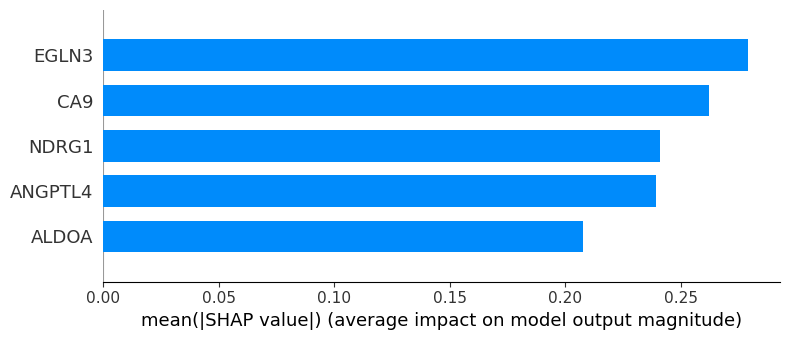

In [18]:
shap.summary_plot(
    shap_values_smart,     # or just shap_values_smart (either works for bar)
    features=None,                # no matrix needed when plot_type="bar"
    feature_names=stable_genes_smart,
    plot_type="bar"
)

#### - *SHAP Value Distribution by Gene*

This violin plot shows the distribution of SHAP values for each gene, colored by expression. Red areas represent higher expression.

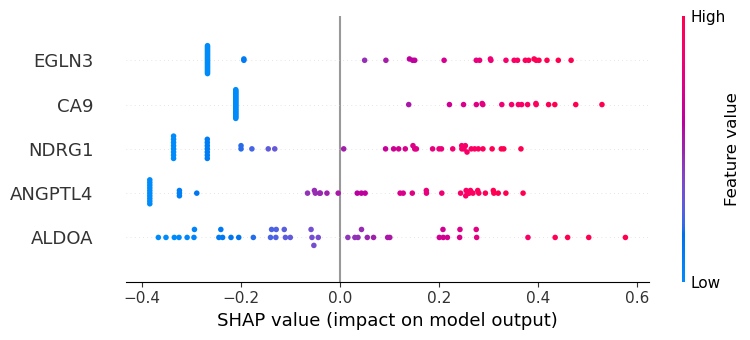

In [19]:
shap.summary_plot(
    shap_values_smart, 
    Xs_test_log,            # unscaled log1p matrix of shape (n_cells, 12)
    feature_names=stable_genes_smart
)

| Plot Feature | Interpretation |
|--------------|----------------|
| **Y-axis (genes)** | Genes ranked by importance (top = most influential) |
| **X-axis (SHAP value)** | Impact on model output:<br> • Positive → pushes toward **Hypoxia (1)**<br> • Negative → pushes toward **Normoxia (0)** |
| **Dot (each point)** | One cell from the test dataset |
| **Dot color** | Expression of the gene in that cell:<br> • **Red** = high expression<br> • **Blue** = low expression |
| **Wider violin (dense points)** | Many cells had similar SHAP impact for that gene |
| **Red dots on the right** | High expression of this gene **increases hypoxia prediction** |
| **Blue dots on the left** | Low expression of this gene **increases normoxia prediction** |
| **Symmetric shape around 0** | Gene has less directional influence; impact is context-specific or neutral |

| Plot Feature | Interpretation |
|--------------|----------------|
| **Y-axis (genes)** | Genes ranked by importance (top = most influential) |
| **X-axis (SHAP value)** | Impact on model output:<br> • Positive → pushes toward **Hypoxia (1)**<br> • Negative → pushes toward **Normoxia (0)** |
| **Dot (each point)** | One cell from the test dataset |
| **Dot color** | Expression of the gene in that cell:<br> • **Red** = high expression<br> • **Blue** = low expression |
| **Wider violin (dense points)** | Many cells had similar SHAP impact for that gene |
| **Red dots on the right** | High expression of this gene **increases hypoxia prediction** |
| **Blue dots on the left** | Low expression of this gene **increases normoxia prediction** |
| **Symmetric shape around 0** | Gene has less directional influence; impact is context-specific or neutral |

**Example Interpretations**

- **EGLN3**: High expression (red) is strongly associated with positive SHAP values → strongly pushes the prediction toward **hypoxia**. Low expression (blue) pushes toward **normoxia**.
- **CA9**: Similar pattern—red dots to the right and blue to the left → upregulation indicates **hypoxic response**.
- **NDRG1**: High expression consistently increases the model's hypoxia confidence, but with slightly more mixed influence than CA9/EGLN3.

This SHAP summary plot offers both a **global ranking** of genes by their predictive power and a **local explanation** of how gene expression levels shift model output across individual cells. It complements the enrichment findings by showing that the same key genes (*EGLN3, CA9, NDRG1, ANGPTL4, ALDOA*) not only are biologically relevant but also **actively drive the classifier's decisions**.


#### - *Local Explanation*

This force plot shows how each gene influences the prediction for an individual cell. Red bars push the prediction toward hypoxia, blue toward normoxia. The longer the bar, the greater the contribution.

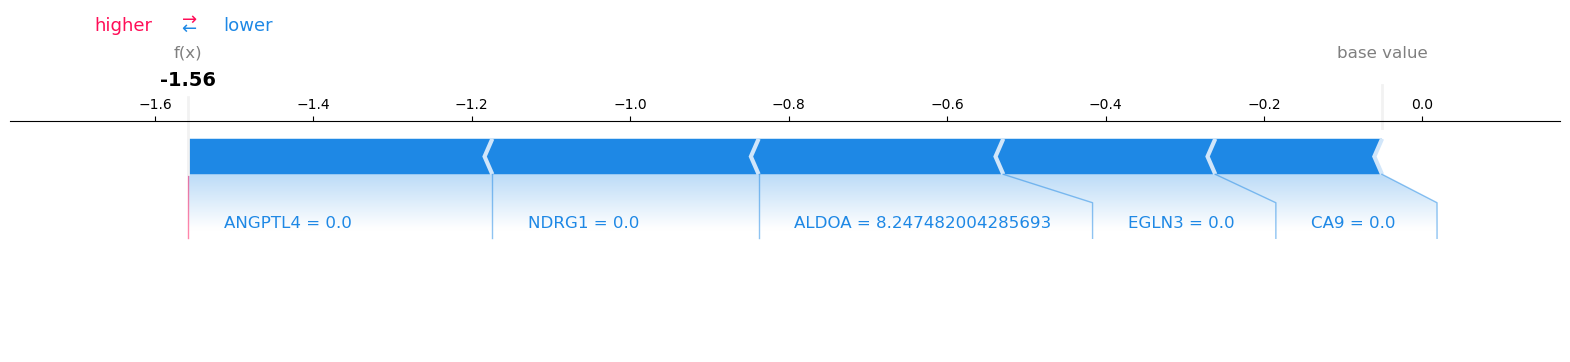

In [20]:
i = 0  # whichever row you want to explain

shap.force_plot(
    explainer_smart.expected_value,        # model’s base output (log-odds)
    shap_values_smart[i],           # SHAP values for cell i (length 12)
    Xs_test_log.iloc[i],             # the UNscaled log1p values of those 12 genes
    feature_names=stable_genes_smart,
    matplotlib=True
)

- **Red bars**: Genes pushing the prediction toward **Hypoxia (1)**.
- **Blue bars**: Genes pushing the prediction toward **Normoxia (0)**.
- **Length of bar**: Magnitude of the gene's contribution.
- **f(x)**: The final logit score before applying the sigmoid (i.e., raw model output).
- **Interpretation**: The force plot explains *why* the model predicted a specific label for one individual cell.


### **5.2.** ***Drop-seq*** *(XGBoost)*
We now interpret the predictions of our XGBoost model trained on Drop-seq data. SHAP will help us identify which genes most influence hypoxia classification in individual test cells.

We start by loading the test dataset and preparing it with the same feature subset used in training (stable genes selected via MI + L1 + RF stability).

In [22]:
df_test_drop = pd.read_csv("../Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_test_anonim.txt", sep=r"\s+", engine= "python", index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"')).T

In [23]:
model_xgb_drop = pickle.load(open("Models_drop/XGBoost.HCC.pkl", "rb"))

In [24]:
# Subset to selected features
Xd_test_subset = df_test_drop[stable_genes_drop]
Xd_test_log_shap = np.log1p(Xd_test_subset)
Xd_test_log_df = pd.DataFrame(
    Xd_test_log_shap,
    index=Xd_test_subset.index,
    columns=stable_genes_drop
)


In [25]:
clf_xgb_drop= model_xgb_drop.named_steps["clf"]

explainer_drop = shap.TreeExplainer(clf_xgb_drop)
shap_values_drop = explainer_drop.shap_values(Xd_test_log_df)

#### - *Global SHAP Feature Importance*

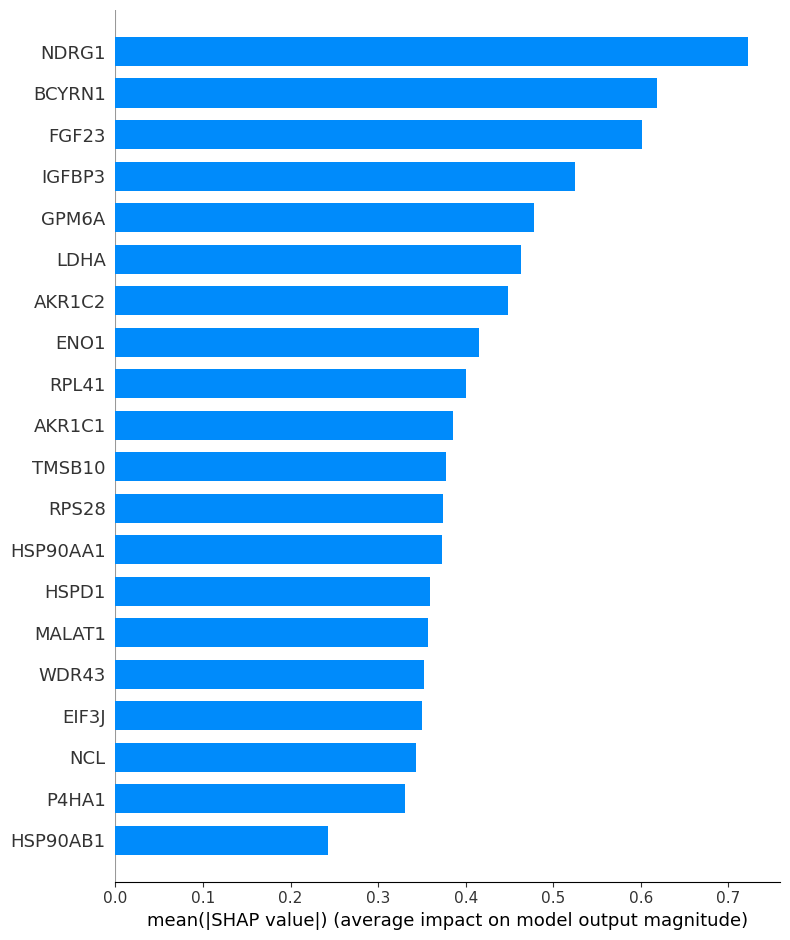

In [26]:
plt.figure(figsize=(6, 4))
shap.summary_plot(
    shap_values_drop, 
    features=None, 
    feature_names=stable_genes_drop,
    plot_type="bar",
    show=True
)

#### - *SHAP Value Distribution by Gene*

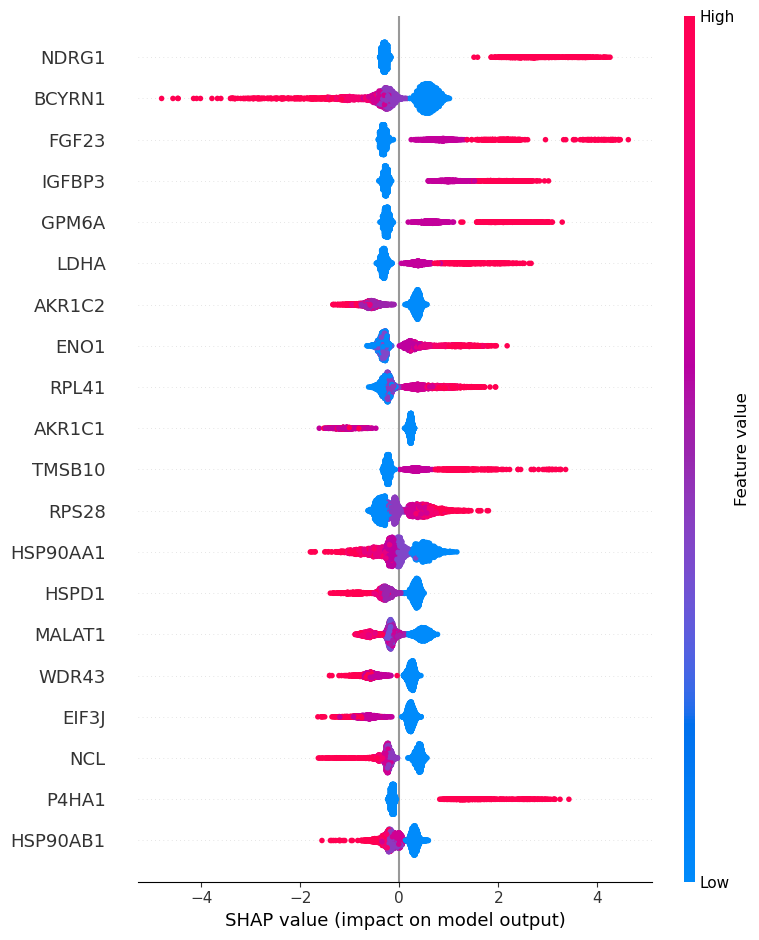

In [27]:
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values_drop,
    Xd_test_log_df,          # unscaled log1p DataFrame for coloring
    feature_names=stable_genes_drop,
    show=True
)

#### - *Local Explanation*

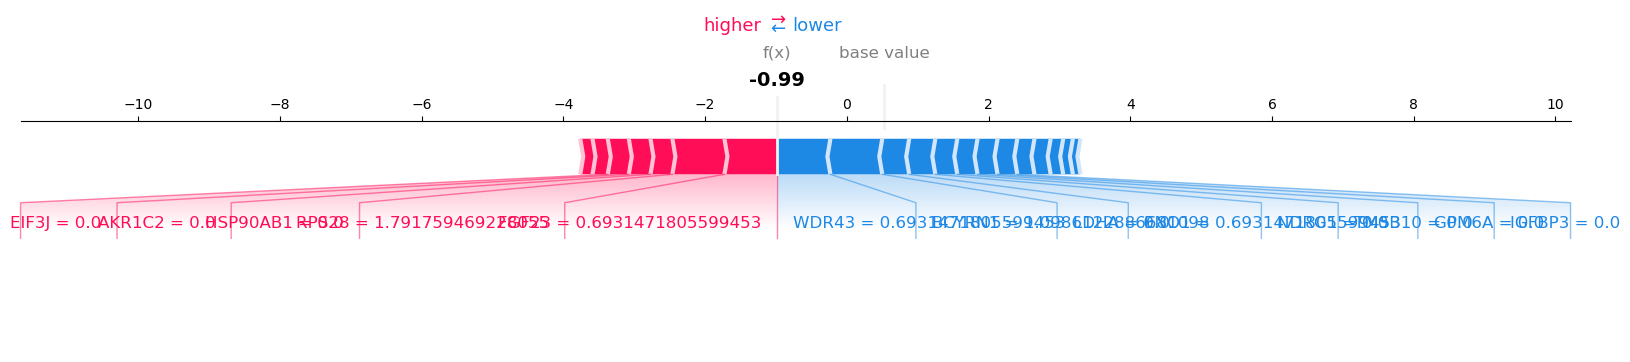

In [28]:
i = 0  # pick a test cell
shap.force_plot(
    explainer_drop.expected_value,
    shap_values_drop[i],
    Xd_test_log_shap.iloc[i],
    matplotlib=True
)

Although our final predictions were generated by an ensemble, we used SHAP to interpret a top-performing and interpretable component (Logistic Regression for Smart-seq, XGBoost for Drop-seq). This allows us to trace biological relevance at the single-gene and single-cell level while maintaining predictive robustness through ensemble voting.